<a href="https://colab.research.google.com/github/sasirekha52/VOIS_AICTE_Oct2025_Netflix-Data-analysis_Sasirekha-V/blob/main/Netflix_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     Year                        Genres  Count
0  2008.0                        Dramas      1
1  2008.0            Independent Movies      1
2  2008.0  Stand-Up Comedy & Talk Shows      1
3  2008.0                     Thrillers      1
4  2009.0                        Dramas      1
     Year Category  Count
0  2008.0    Movie      1
1  2008.0  TV Show      1
2  2009.0    Movie      2
3  2010.0    Movie      1
4  2011.0    Movie     13
     Year                        Genres  Avg_Rating_Score  Avg_Watch_Status  \
0  2008.0                        Dramas               8.0               1.0   
1  2008.0            Independent Movies               8.0               1.0   
2  2008.0  Stand-Up Comedy & Talk Shows               8.0               0.0   
3  2008.0                     Thrillers               8.0               1.0   
4  2009.0                        Dramas               8.0               1.0   

   Titles  
0       1  
1       1  
2       1  
3       1  
4       1  


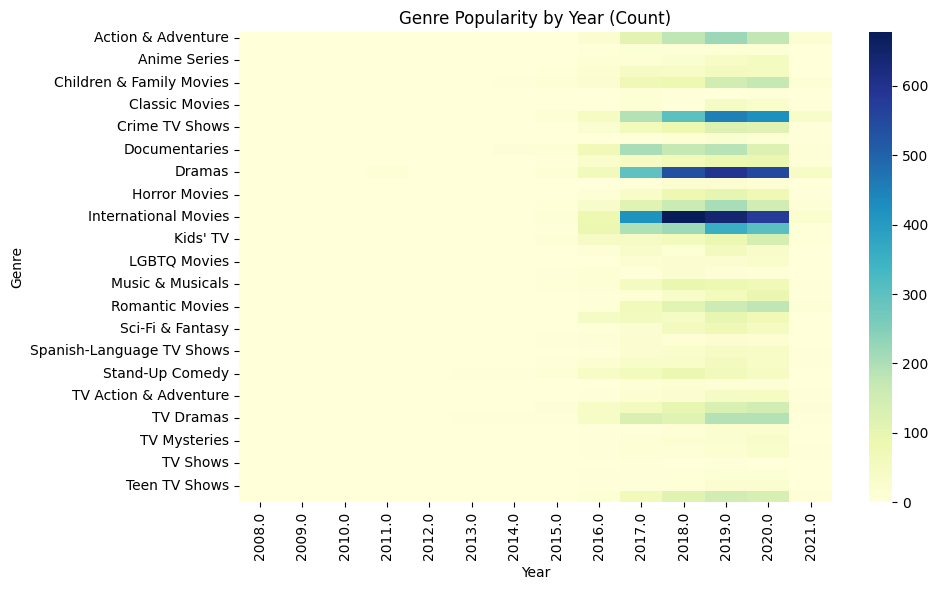

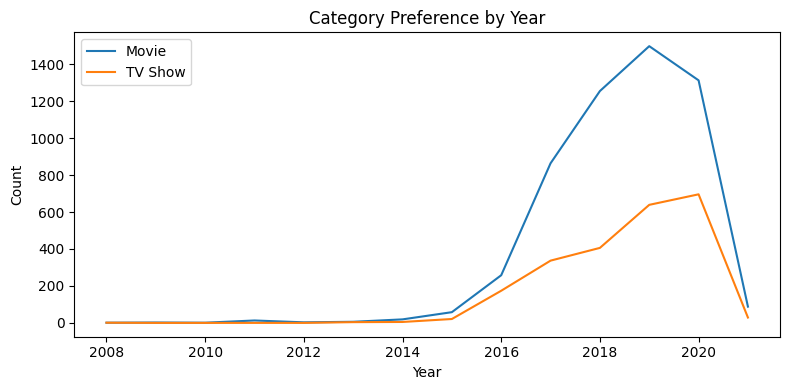

Built dataframes: genre_year_counts, cat_year_counts, genre_year_avgs; created two plots.


In [ ]:
# Build trend analysis: genre popularity by year, category preference by year, and average rating/watch status by genre-year.
# Assumptions: Release_Date is a string like 'August 14, 2020'; Type holds comma-separated genres; no watch status column exists so we will simulate a placeholder if missing.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use existing dataframe if present, else load
try:
    netflix_df
except NameError:
    # Handle potential errors in CSV by skipping bad lines
    netflix_df = pd.read_csv('/content/Netflix Dataset.csv', encoding='utf-8', on_bad_lines='skip')

# Parse year from Release_Date
netflix_df['Year'] = pd.to_datetime(netflix_df['Release_Date'], errors='coerce').dt.year

# Split Type into list of genres
netflix_df['Genres'] = netflix_df['Type'].fillna('').str.split(',').apply(lambda lst: [g.strip() for g in lst if g.strip() != ''])

# Explode by genre for per-genre analysis
exploded = netflix_df.explode('Genres')

# Genre popularity by year (counts)
genre_year_counts = exploded.groupby(['Year','Genres']).size().reset_index(name='Count')
print(genre_year_counts.head())

# Category preference by year (Movie vs TV Show counts)
cat_year_counts = netflix_df.groupby(['Year','Category']).size().reset_index(name='Count')
print(cat_year_counts.head())

# Handle ratings: convert common TV ratings to an ordinal-ish scale for averaging
rating_order = ['G','TV-Y','TV-Y7','PG','TV-PG','TV-14','PG-13','R','TV-MA','NC-17']
rating_map = {r:i for i,r in enumerate(rating_order)}
netflix_df['Rating_Score'] = netflix_df['Rating'].map(rating_map)
exploded['Rating_Score'] = exploded['Rating'].map(rating_map)

# Watch status: if missing, create a dummy based on simple heuristic (longer durations more likely watched)
if 'Watch_Status' not in netflix_df.columns:
    # Create a simple probability of watched from duration minutes when available
    def parse_minutes(x):
        if pd.isna(x):
            return np.nan
        s = str(x)
        if 'Season' in s:
            return np.nan
        try:
            return pd.to_numeric(s.split(' ')[0], errors='coerce')
        except Exception:
            return np.nan
    netflix_df['Minutes'] = netflix_df['Duration'].apply(parse_minutes)
    prob = (netflix_df['Minutes'].fillna(netflix_df['Minutes'].median())).clip(lower=0)
    if prob.notna().any():
        prob = (prob - prob.min()) / (prob.max() - prob.min() + 1e-9)
    else:
        prob = pd.Series(np.zeros(len(netflix_df)))
    rng = np.random.default_rng(42)
    netflix_df['Watch_Status'] = rng.binomial(1, prob).astype(int)
    exploded = exploded.merge(netflix_df[['Show_Id','Watch_Status']], on='Show_Id', how='left')

# Averages by genre and year
genre_year_avgs = exploded.groupby(['Year','Genres']).agg(
    Avg_Rating_Score=('Rating_Score','mean'),
    Avg_Watch_Status=('Watch_Status','mean'),
    Titles=('Show_Id','nunique')
).reset_index()
print(genre_year_avgs.head())

# Quick visuals: heatmap of genre popularity by year; line plot Movies vs TV Shows by year
try:
    pivot_counts = genre_year_counts.pivot_table(index='Genres', columns='Year', values='Count', fill_value=0)
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_counts, cmap='YlGnBu')
    plt.title('Genre Popularity by Year (Count)')
    plt.xlabel('Year')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    cat_pivot = cat_year_counts.pivot_table(index='Year', columns='Category', values='Count', fill_value=0).sort_index()
    for c in cat_pivot.columns:
        plt.plot(cat_pivot.index, cat_pivot[c], label=c)
    plt.title('Category Preference by Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('Built dataframes: genre_year_counts, cat_year_counts, genre_year_avgs; created two plots.')

except Exception as e:
    print(f"An error occurred during plotting: {e}")